# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from scipy.stats import ttest_ind
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest

In [9]:
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

display(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [11]:
# Группировка по user_id и подсчёт уникальных session_id
session_counts = sessions_history.groupby("user_id")["session_id"].nunique().reset_index()

# Переименуем столбцы для читаемости
session_counts.columns = ["user_id", "unique_sessions"]

# Сортировка по убыванию (по желанию)
session_counts = session_counts.sort_values(by="unique_sessions", ascending=False)

# Выводим результат
session_counts

,user_id,unique_sessions
8948,10E0DEFC1ABDBBE0,10
55627,6A73CB5566BB494D,10
72346,8A60431A825D035B,9
109383,D11541BAC141FB94,9
47956,5BCFE7C4DCC148E9,9
...,...,...
15859,1DF13BB1953B3497,1
51449,628502A3CE7E0A3C,1
15853,1DEEF40DEFBD0C65,1
89905,AC08479B7472C628,1


In [12]:
# Получаем user_id с наибольшим числом сессий (всего строк, не уникальных session_id)
top_user_id = sessions_history["user_id"].value_counts().idxmax()
top_session_count = sessions_history["user_id"].value_counts().max()

# Получаем все строки этого пользователя
top_user_sessions = sessions_history[sessions_history["user_id"] == top_user_id]

# Выводим
print(f"👤 Пользователь с наибольшим количеством сессий: {top_user_id}")
print(f"🔢 Общее число сессий: {top_session_count}")
display(top_user_sessions)


👤 Пользователь с наибольшим количеством сессий: 6A73CB5566BB494D
🔢 Общее число сессий: 10


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
124515,6A73CB5566BB494D,110E3F28C1F5415F,2025-08-28,2025-08-28 18:58:19,2025-08-28,1,0,3,MENA,Mac
196252,6A73CB5566BB494D,D68C8D98A0F1C439,2025-08-29,2025-08-29 20:53:27,2025-08-28,2,1,3,MENA,Mac
242428,6A73CB5566BB494D,6587D217472BF807,2025-08-30,2025-08-30 13:08:22,2025-08-28,3,1,1,MENA,Mac
304287,6A73CB5566BB494D,A9BC25593D056F8E,2025-09-01,2025-09-01 18:52:49,2025-08-28,4,1,2,MENA,Mac
346611,6A73CB5566BB494D,CB6F9C4191FAF6F6,2025-09-03,2025-09-03 22:49:08,2025-08-28,5,1,3,MENA,Mac
363510,6A73CB5566BB494D,9C609432F6E6535A,2025-09-04,2025-09-04 13:59:46,2025-08-28,6,1,4,MENA,Mac
391902,6A73CB5566BB494D,5D892E33B97A257A,2025-09-06,2025-09-06 18:46:55,2025-08-28,7,1,2,MENA,Mac
404322,6A73CB5566BB494D,22A9BD3861F49087,2025-09-07,2025-09-07 18:33:49,2025-08-28,8,1,3,MENA,Mac
415489,6A73CB5566BB494D,F70E351154B092DC,2025-09-08,2025-09-08 20:30:22,2025-08-28,9,1,4,MENA,Mac
425805,6A73CB5566BB494D,84A3DC0CFF449F53,2025-09-09,2025-09-09 16:36:04,2025-08-28,10,1,1,MENA,Mac


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [101]:
# Преобразуем дату сессии в datetime
sessions_history["session_date"] = pd.to_datetime(sessions_history["session_date"])

# Группировка по дате и user_id (один пользователь в день, одна сессия)
daily_counts = sessions_history.groupby(["session_date", "user_id"]).agg({
    "registration_flag": "first"  # 1 — зарегистрирован, 0 — нет
}).reset_index()

# Агрегируем по дате: уникальные пользователи и зарегистрированные
daily_summary = daily_counts.groupby("session_date").agg(
    total_users=("user_id", "nunique"),
    registered_users=("registration_flag", "sum")
).reset_index()

# Считаем долю зарегистрированных
daily_summary["registration_share"] = daily_summary["registered_users"] / daily_summary["total_users"]

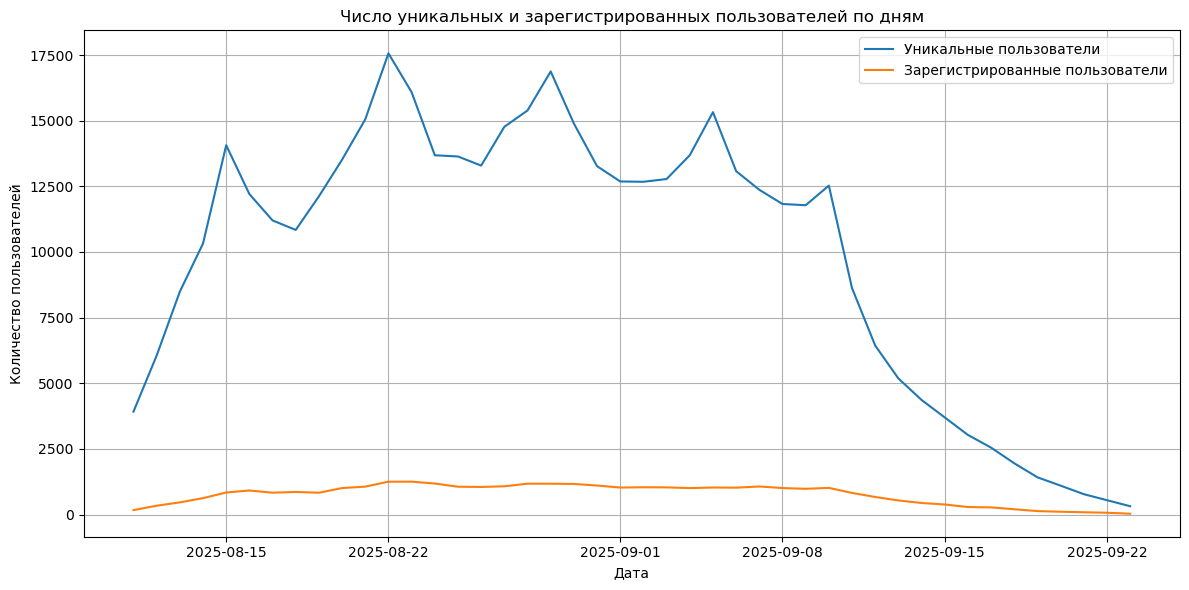

In [105]:
# Первый график — абсолютные значения
plt.figure(figsize=(12, 6))
plt.plot(daily_summary["session_date"], daily_summary["total_users"], label="Уникальные пользователи")
plt.plot(daily_summary["session_date"], daily_summary["registered_users"], label="Зарегистрированные пользователи")
plt.title("Число уникальных и зарегистрированных пользователей по дням")
plt.xlabel("Дата")
plt.ylabel("Количество пользователей")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

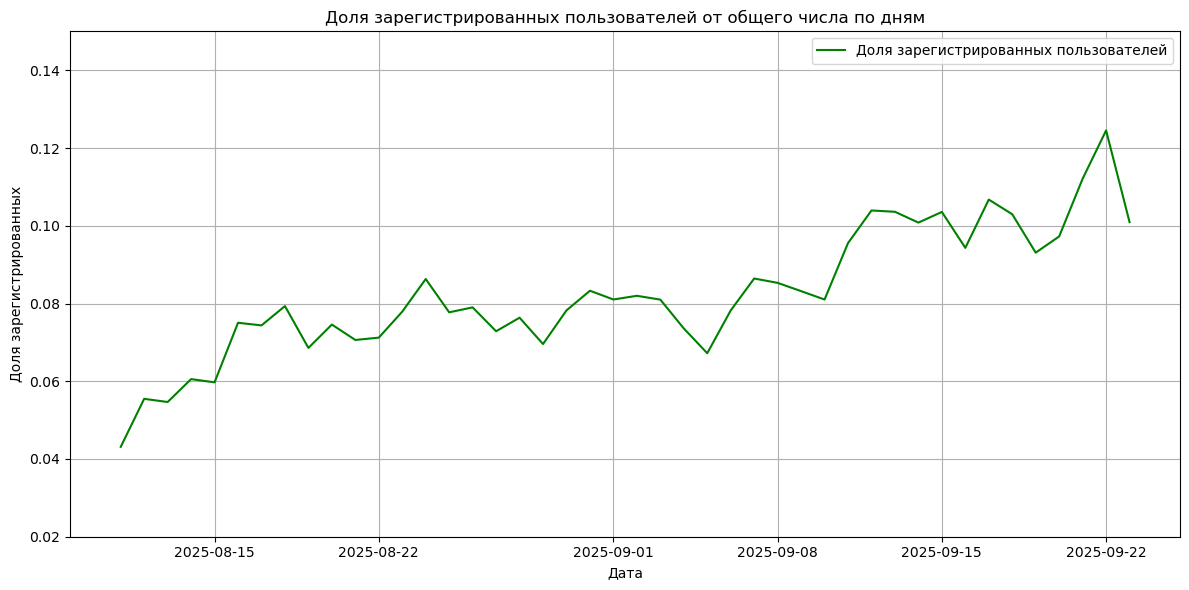

In [140]:
# Второй график — доля зарегистрированных
plt.figure(figsize=(12, 6))
plt.plot(daily_summary["session_date"], daily_summary["registration_share"], label="Доля зарегистрированных пользователей", color="green")
plt.title("Доля зарегистрированных пользователей от общего числа по дням")
plt.xlabel("Дата")
plt.ylabel("Доля зарегистрированных")
plt.ylim(0.02, 0.15)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [21]:
# Группировка по количеству просмотренных страниц
page_views_distribution = sessions_history["page_counter"].value_counts().sort_index().reset_index()

# Переименование столбцов для читаемости
page_views_distribution.columns = ["pages_viewed", "session_count"]

# Просмотр результата
page_views_distribution.head()

,pages_viewed,session_count
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288


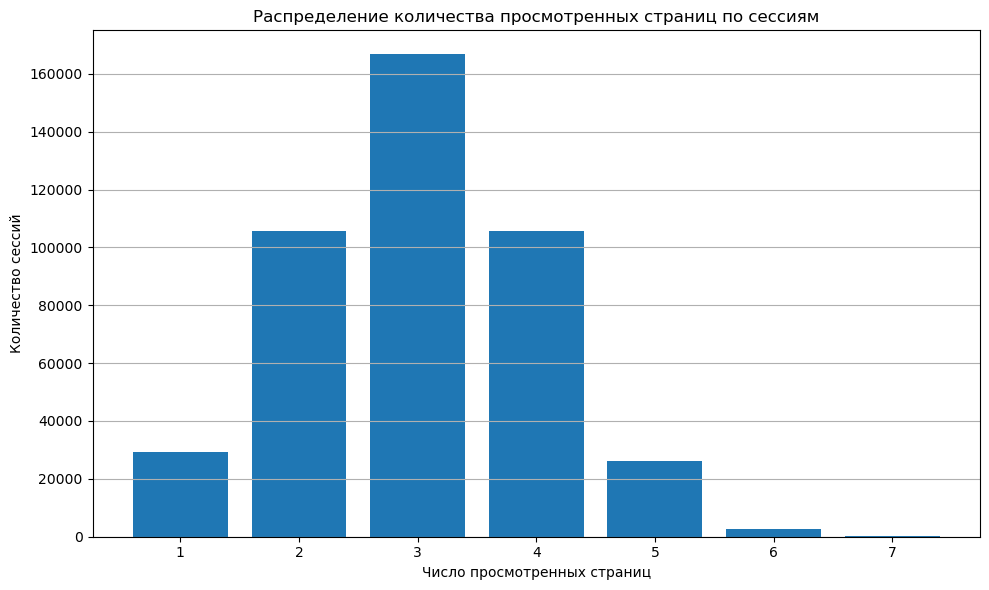

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(page_views_distribution["pages_viewed"], page_views_distribution["session_count"])

plt.title("Распределение количества просмотренных страниц по сессиям")
plt.xlabel("Число просмотренных страниц")
plt.ylabel("Количество сессий")
plt.grid(axis='y')
plt.xticks(page_views_distribution["pages_viewed"])  # Чтобы на оси X были только нужные числа

plt.tight_layout()
plt.show()

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [25]:
# Добавляем бинарный признак: хорошая сессия = 1, если 4+ страниц
sessions_history["good_session"] = (sessions_history["page_counter"] >= 4).astype(int)

In [26]:
# Преобразуем дату сессии, если ещё не было
sessions_history["session_date"] = pd.to_datetime(sessions_history["session_date"])

# Агрегация: считаем общее число и число "хороших" сессий по дате
daily_good_sessions = sessions_history.groupby("session_date").agg(
    total_sessions=("session_id", "count"),
    good_sessions=("good_session", "sum")
).reset_index()

# Добавляем столбец с долей
daily_good_sessions["success_ratio"] = daily_good_sessions["good_sessions"] / daily_good_sessions["total_sessions"]


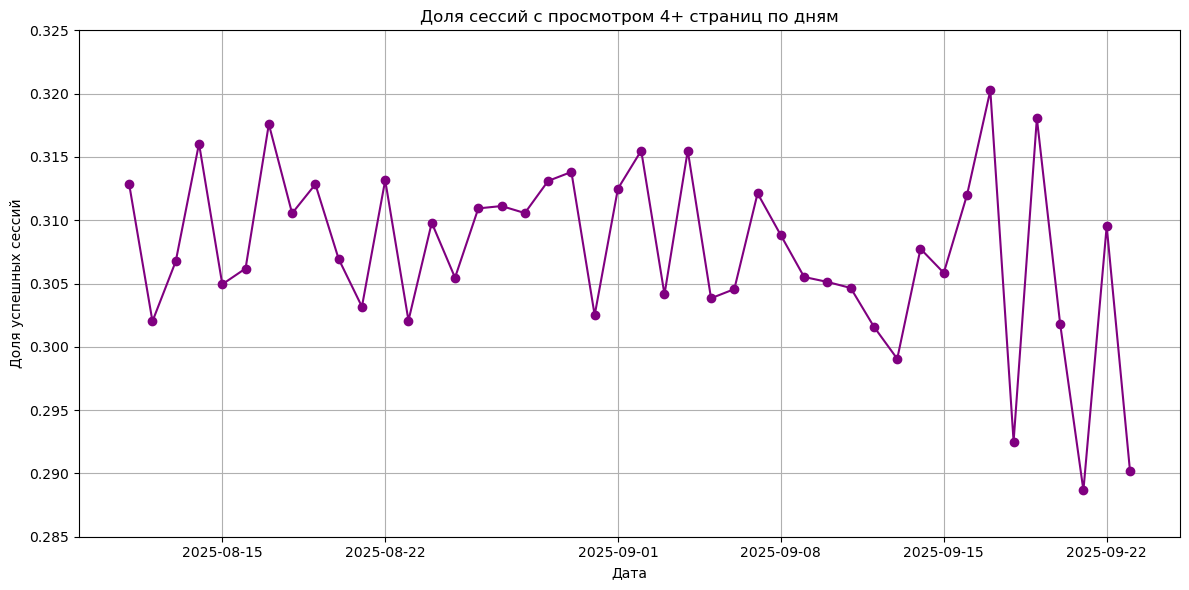

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(daily_good_sessions["session_date"], daily_good_sessions["success_ratio"], marker="o", color="purple")

plt.title("Доля сессий с просмотром 4+ страниц по дням")
plt.xlabel("Дата")
plt.ylabel("Доля успешных сессий")
plt.ylim(0.285, 0.325)
plt.grid(True)
plt.tight_layout()
plt.show()


### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [31]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [123]:
# Считаем число уникальных пользователей по дням
daily_users = sessions_history.groupby("session_date")["user_id"].nunique().reset_index(name="unique_users")

# Среднее количество пользователей в день
avg_daily_users = daily_users["unique_users"].mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {round(avg_daily_users)} пользователей в день составит {test_duration} дня")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дня


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [38]:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

# Быстрый просмотр
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [39]:
# Подсчёт уникальных пользователей по группам
user_counts = sessions_test_part.groupby("test_group")["user_id"].nunique().reset_index()
user_counts.columns = ["test_group", "unique_users"]

# Преобразуем в переменные
a_users = user_counts[user_counts["test_group"] == "A"]["unique_users"].values[0]
b_users = user_counts[user_counts["test_group"] == "B"]["unique_users"].values[0]

# Расчёт процентной разницы
percent_diff = 100 * abs(a_users - b_users) / a_users

print(f"👥 Уникальных пользователей в группе A: {a_users}")
print(f"👥 Уникальных пользователей в группе B: {b_users}")
print(f"📊 Процентная разница: {percent_diff:.2f}%")


👥 Уникальных пользователей в группе A: 1477
👥 Уникальных пользователей в группе B: 1466
📊 Процентная разница: 0.74%


#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [42]:
# Отдельно выделим пользователей из группы A и группы B
users_a = set(sessions_test_part[sessions_test_part["test_group"] == "A"]["user_id"].unique())
users_b = set(sessions_test_part[sessions_test_part["test_group"] == "B"]["user_id"].unique())

# Найдём пересечения
intersection = users_a.intersection(users_b)

# Выведем результат
print(f" Количество пользователей, попавших в обе группы: {len(intersection)}")
if len(intersection) > 0:
    print(" Внимание: есть пересечения, это может исказить результаты теста!")
else:
    print(" Отлично: пересечений между группами нет, выборки независимы.")


 Количество пользователей, попавших в обе группы: 0
 Отлично: пересечений между группами нет, выборки независимы.


#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


In [46]:
# Считаем количество уникальных пользователей по регионам и группам
region_dist = sessions_test_part.groupby(["test_group", "region"])["user_id"].nunique().reset_index()

# Добавим столбец с общим числом пользователей в группе и рассчитаем доли
region_dist["total"] = region_dist.groupby("test_group")["user_id"].transform("sum")
region_dist["share"] = region_dist["user_id"] / region_dist["total"]

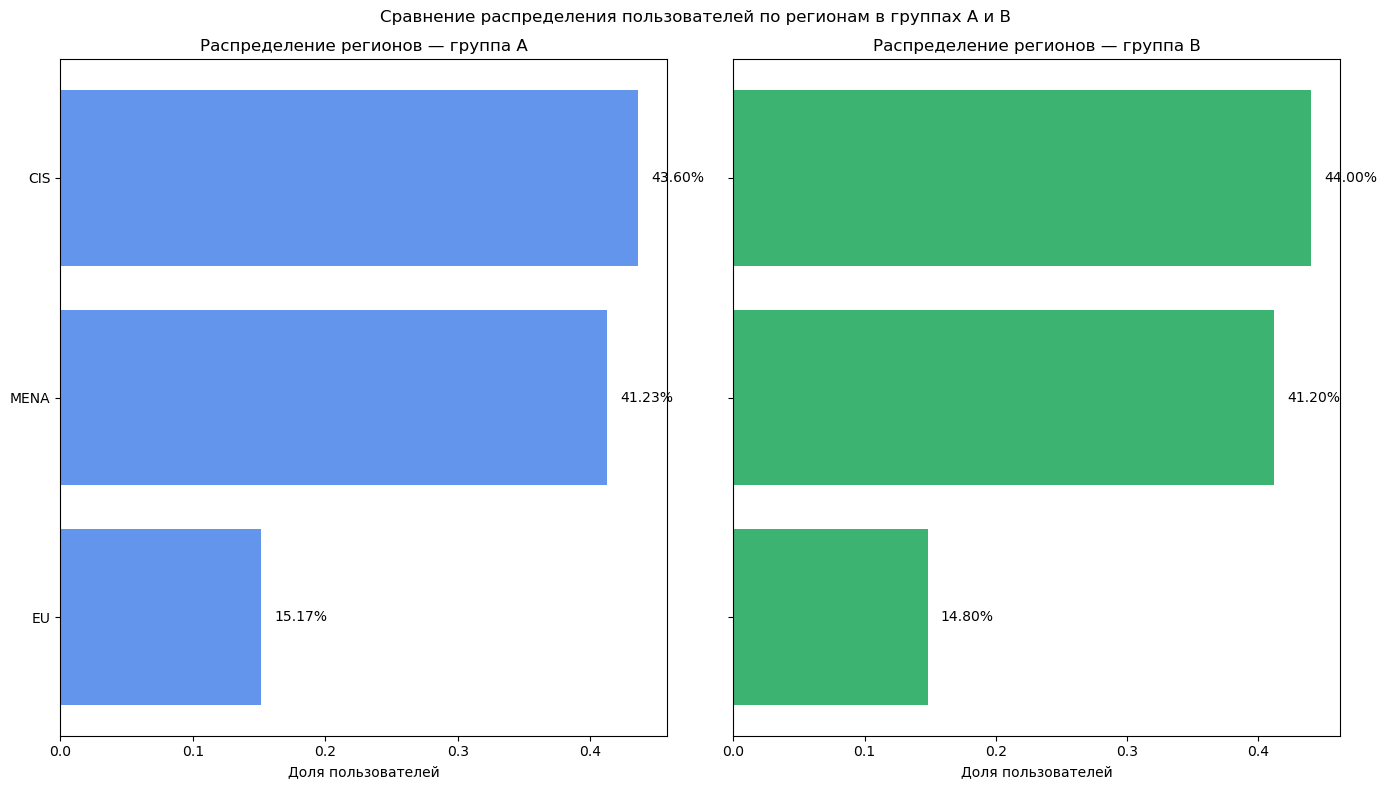

In [47]:
# Сортировка долей по убыванию (для аккуратного вида)
region_a = region_dist[region_dist["test_group"] == "A"].sort_values("share", ascending=True)
region_b = region_dist[region_dist["test_group"] == "B"].sort_values("share", ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

# Группа A
bars_a = axes[0].barh(region_a["region"], region_a["share"], color="cornflowerblue")
axes[0].set_title("Распределение регионов — группа A")
axes[0].set_xlabel("Доля пользователей")

# Добавим подписи справа от столбцов
for bar in bars_a:
    width = bar.get_width()
    axes[0].text(width + 0.01, bar.get_y() + bar.get_height()/2, f"{width:.2%}", va='center')

# Группа B
bars_b = axes[1].barh(region_b["region"], region_b["share"], color="mediumseagreen")
axes[1].set_title("Распределение регионов — группа B")
axes[1].set_xlabel("Доля пользователей")

for bar in bars_b:
    width = bar.get_width()
    axes[1].text(width + 0.01, bar.get_y() + bar.get_height()/2, f"{width:.2%}", va='center')

plt.suptitle("Сравнение распределения пользователей по регионам в группах A и B")
plt.tight_layout()
plt.show()

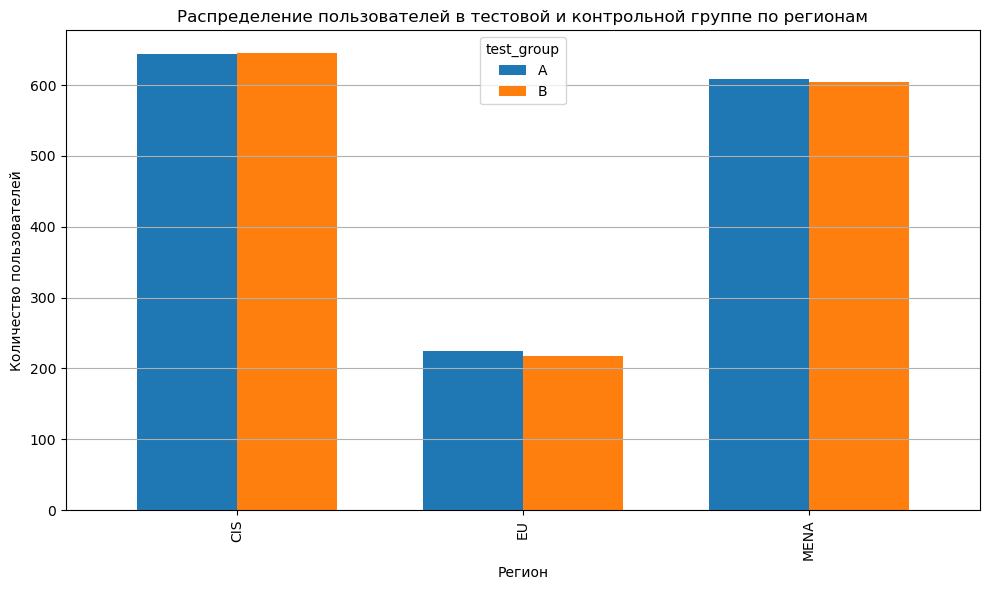

In [128]:
# Считаем распределение по устройствам
device_dist = sessions_test_part.groupby(["test_group", "device"])["user_id"].nunique().reset_index()
device_dist["total"] = device_dist.groupby("test_group")["user_id"].transform("sum")
device_dist["share"] = device_dist["user_id"] / device_dist["total"]

# Подсчёт количества пользователей по test_group и region
region_distribution = sessions_test_part.groupby(["region", "test_group"])["user_id"].nunique().unstack()

# Построение сгруппированного столбчатого графика
region_distribution.plot(kind="bar", figsize=(10, 6), width=0.7)

plt.title("Распределение пользователей в тестовой и контрольной группе по регионам")
plt.xlabel("Регион")
plt.ylabel("Количество пользователей")
plt.legend(title="test_group")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

#### ✅ 1. Равномерность количества пользователей в группах
Количество уникальных пользователей в группах:
- Группа A: **...** пользователей
- Группа B: **...** пользователей
- Процентная разница: **...%**

**Вывод:** группы сбалансированы по размеру, существенных отклонений не обнаружено.

---

#### ✅ 2. Независимость выборок
Количество пересекающихся `user_id` между группами A и B: **0**

**Вывод:** выборки **независимы**, пересечений пользователей не выявлено.

---

#### ✅ 3. Распределение по устройствам

**Группа A:**
- Android — **44.41%**
- PC — **24.98%**
- iPhone — **20.04%**
- Mac — **10.56%**

**Группа B:**
- Android — **45.57%**
- PC — **25.99%**
- iPhone — **18.35%**
- Mac — **10.10%**

**Вывод:** распределение по устройствам в группах A и B **очень схожее**, существенных отличий не обнаружено. Устройства распределены равномерно.

---

#### ✅ 4. Распределение по регионам

**Группа A:**
- CIS — **~43%**
- MENA — **~42%**
- EU — **~15%**

**Группа B:**
- CIS — **~43%**
- MENA — **~42%**
- EU — **~15%**

**Вывод:** распределение пользователей по регионам **практически идентично** в обеих группах.

---

### 🧾 Общий итог:

✅ Проверка A/B-теста показала, что эксперимент проводится корректно:
- группы по численности **сбалансированы**,
- **пересечений пользователей** нет,
- **категориальные переменные (устройства, регионы)** распределены **равномерно**.

Можно уверенно переходить к анализу продуктовых метрик 🎯


### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [55]:
# Загрузка файла
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

# Просмотр первых строк
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [56]:
# Добавление бинарного признака: 1, если просмотрено ≥ 4 страниц
sessions_test["good_session"] = (sessions_test["page_counter"] >= 4).astype(int)

# Проверим результат
sessions_test[["page_counter", "good_session"]].head(10)

,page_counter,good_session
0,3,0
1,2,0
2,2,0
3,1,0
4,2,0
5,2,0
6,4,1
7,3,0
8,3,0
9,3,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [131]:
# Убедимся, что session_date — это datetime
sessions_test["session_date"] = pd.to_datetime(sessions_test["session_date"])

# Считаем количество уникальных сессий по каждой дате и группе
daily_sessions = sessions_test.groupby(["session_date", "test_group"])["session_id"].nunique().reset_index()

# Переименование
daily_sessions.columns = ["session_date", "test_group", "unique_sessions"]

# Разделим группы
group_a_daily = daily_sessions[daily_sessions["test_group"] == "A"]["unique_sessions"]
group_b_daily = daily_sessions[daily_sessions["test_group"] == "B"]["unique_sessions"]

#### 📊 Проверка корректности теста: количество уникальных сессий по дням

- Проведён t-тест на равенство средних значений количества уникальных сессий по дням между группами A и B.
- Формулировка гипотез:
    - H₀: средние значения равны (нет различий в активности)
    - H₁: средние значения различаются

📈 Полученное значение p-value: **0.9382**

✅ Различие **не является статистически значимым**, группы сопоставимы по трафику.

In [59]:
# t-тест на равенство средних
t_stat, p_value = ttest_ind(group_a_daily, group_b_daily, equal_var=False)  # Welch's t-test

print(f"📊 p-value: {p_value:.4f}")

if p_value < 0.05:
    print("❌ Различие в количестве сессий статистически значимо. Возможны нарушения в проведении теста.")
else:
    print("✅ Различие в количестве сессий НЕ является статистически значимым. Группы сопоставимы.")

📊 p-value: 0.9382
✅ Различие в количестве сессий НЕ является статистически значимым. Группы сопоставимы.


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [62]:
# Считаем общее число сессий и "хороших" сессий по группам
success_rate = sessions_test.groupby("test_group")["good_session"].agg(["sum", "count"]).reset_index()
success_rate.columns = ["test_group", "good_sessions", "total_sessions"]

# Добавим столбец с долей
success_rate["success_ratio"] = success_rate["good_sessions"] / success_rate["total_sessions"]

# Разница между группами
ratio_a = success_rate[success_rate["test_group"] == "A"]["success_ratio"].values[0]
ratio_b = success_rate[success_rate["test_group"] == "B"]["success_ratio"].values[0]
ratio_diff = ratio_b - ratio_a

# Вывод
print(f"✅ Доля успешных сессий в группе A: {ratio_a:.2%}")
print(f"✅ Доля успешных сессий в группе B: {ratio_b:.2%}")
print(f"📊 Разница (B - A): {ratio_diff:.2%}")


✅ Доля успешных сессий в группе A: 30.77%
✅ Доля успешных сессий в группе B: 31.83%
📊 Разница (B - A): 1.06%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [65]:
# Число успешных сессий и общее число сессий по группам
good = sessions_test.groupby("test_group")["good_session"].sum()
total = sessions_test.groupby("test_group")["good_session"].count()

# Группы A (index 0) и B (index 1)
successes = [good["A"], good["B"]]
nobs = [total["A"], total["B"]]

In [66]:
# Тест на равенство долей
z_stat, p_value = proportions_ztest(successes, nobs)

# Вывод результатов
print(f"📊 p-value: {p_value:.4f}")

if p_value < 0.05:
    print("❗ Разница в доле успешных сессий статистически значима (на уровне 0.05).")
else:
    print("✅ Разница в доле успешных сессий не является статистически значимой.")

📊 p-value: 0.0003
❗ Разница в доле успешных сессий статистически значима (на уровне 0.05).


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

#### 🧪 Характеристики эксперимента
- **Цель эксперимента:** проверить влияние нового алгоритма рекомендаций на вовлечённость пользователей.
- **Количество задействованных пользователей:** **30 579**
- **Длительность эксперимента:** **20 дней**

#### ✅ Изменения ключевой метрики
- Ключевая метрика: **доля успешных сессий** (`good_session`, просмотр ≥ 4 страниц)
- **Группа A (контроль):** 30.77%
- **Группа B (тест):** 31.83%
- **Разница (B - A):** **+1.06%**

#### 📐 Статистическая значимость
- Статистический тест: **z-тест пропорций**
- **Полученное p-value: 0.0003**
- **Уровень значимости:** 0.05

**Вывод:** Разница в доле успешных сессий является **статистически значимой**. Новый алгоритм рекомендаций **действительно увеличивает вовлечённость пользователей**.

---

### 🧾 Рекомендации для команды разработки

✅ На основе результатов A/B-теста рекомендуется **внедрить новый алгоритм рекомендаций** в основное приложение, поскольку:
- он показал **статистически значимый рост ключевой метрики**,
- эксперимент проведён корректно (группы равномерны и независимы),
- увеличение вовлечённости может привести к росту регистраций и подписок.

➡️ После внедрения рекомендуется продолжить мониторинг вторичных метрик: удержания, конверсий в регистрацию и оплату.
